In [1]:
using VegaDatasets, DataFrames, PyPlot, LinearAlgebra

┌ Info: Precompiling VegaDatasets [0ae4a718-28b7-58ec-9efb-cded64d6d5b4]
└ @ Base loading.jl:1273
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273


In [2]:
df = DataFrame(dataset("cars"));

In [3]:
show(first(df, 3), allcols=true)

3×9 DataFrame
│ Row │ Name                      │ Miles_per_Gallon │ Cylinders │
│     │ String                    │ Float64?         │ Int64     │
├─────┼───────────────────────────┼──────────────────┼───────────┤
│ 1   │ chevrolet chevelle malibu │ 18.0             │ 8         │
│ 2   │ buick skylark 320         │ 15.0             │ 8         │
│ 3   │ plymouth satellite        │ 18.0             │ 8         │

│ Row │ Displacement │ Horsepower │ Weight_in_lbs │ Acceleration │ Year       │
│     │ Float64      │ Int64?     │ Int64         │ Float64      │ String     │
├─────┼──────────────┼────────────┼───────────────┼──────────────┼────────────┤
│ 1   │ 307.0        │ 130        │ 3504          │ 12.0         │ 1970-01-01 │
│ 2   │ 350.0        │ 165        │ 3693          │ 11.5         │ 1970-01-01 │
│ 3   │ 318.0        │ 150        │ 3436          │ 11.0         │ 1970-01-01 │

│ Row │ Origin │
│     │ String │
├─────┼────────┤
│ 1   │ USA    │
│ 2   │ USA    │
│ 3   │ USA    │

In [4]:
dfclean = dropmissing(df);

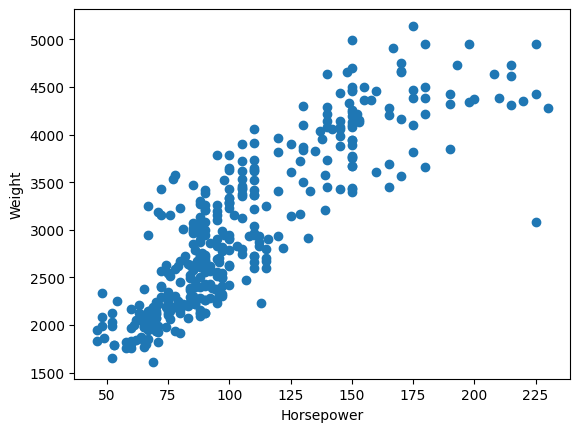

In [6]:
scatter(dfclean.Horsepower, dfclean.Weight_in_lbs);
xlabel("Horsepower");
ylabel("Weight");

In [12]:
function h(x, θ)
    dot(x, θ)
end

h (generic function with 2 methods)

In [13]:
# Example:
h([1.,2.,3.], [0.1, 0.2, -0.3])

-0.3999999999999999

# Batch Gradient Descent

In [14]:
function BGD(h, X, Y, α, θinit, ϵ, maxiter)
    converged = false
    θ = θinit
    counter = 0
    X = hcat(ones(size(X, 1)), X)  # for the intercept θ_0
    while ~ converged
        counter += 1
        gradient = zeros(size(θ))
        for i in 1:size(X, 1)
            x = @view X[i, :]
            y = Y[i]
            gradient = gradient + (y - h(x, θ)) * x
        end
        θ = θ + α * gradient 
        if maximum(abs.(gradient)) < ϵ || counter >= maxiter
            converged = true
        end
    end
    θ
end

BGD (generic function with 1 method)

In [15]:
X = reshape(dfclean.Horsepower, length(dfclean.Horsepower), 1);
Y = dfclean.Weight_in_lbs;

In [16]:
θ = BGD(h, X, Y, 1e-9, [0.1, 0.1], 1e-4, 5000)

2-element Array{Float64,1}:
  0.5599516370322432
 27.373481144955623 

In [17]:
xplot = hcat(ones(2), [minimum(dfclean.Horsepower), maximum(dfclean.Horsepower)])

2×2 Array{Float64,2}:
 1.0   46.0
 1.0  230.0

In [18]:
yplot = [h(x, θ) for x in eachrow(xplot)]

2-element Array{Float64,1}:
 1259.740084304991
 6296.460614976825

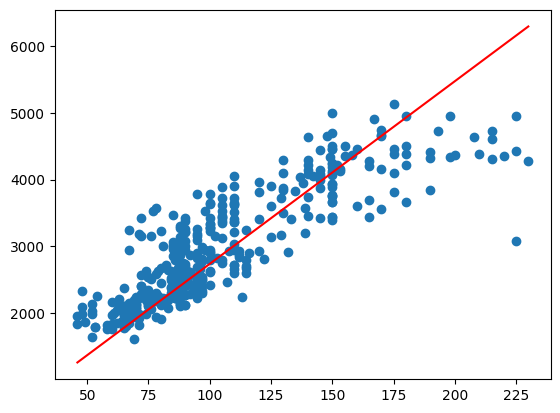

In [20]:
scatter(dfclean.Horsepower, dfclean.Weight_in_lbs);
plot(xplot[:, 2], yplot, color="red");

# Stochastic Gradient Descent

In [21]:
function SGD(h, X, Y, α, θinit, ϵ, maxiter)
    converged = false
    θold = θinit
    counter = 0
    X = hcat(ones(size(X, 1)), X)  # for the intercept θ_0
    θnew = Array{Float64}(undef, size(X, 2))
    while ~ converged
        counter += 1
        θnew = θold
        for i in 1:size(X, 1)
            x = X[i, :]
            y = Y[i]
            gradient = (y - h(x, θnew)) * x
            θnew = θnew + α * gradient 
        end
        if sum(abs.(θold - θnew)) < ϵ || counter >= maxiter
            converged = true
            println(counter, " ", abs.(θold - θnew))
        end
        θold = θnew
    end
    θnew
end

SGD (generic function with 1 method)

In [22]:
θ = SGD(h, X, Y, 1e-7, [1000, 0.1], 1e-8, 10000)

10000 [0.00011192659542302863, 9.675713705803446e-7]


2-element Array{Float64,1}:
 999.0096910288355  
  19.037891019756145

In [23]:
yplot = [h(x, θ) for x in eachrow(xplot)]

2-element Array{Float64,1}:
 1874.752677937618
 5377.72462557275 

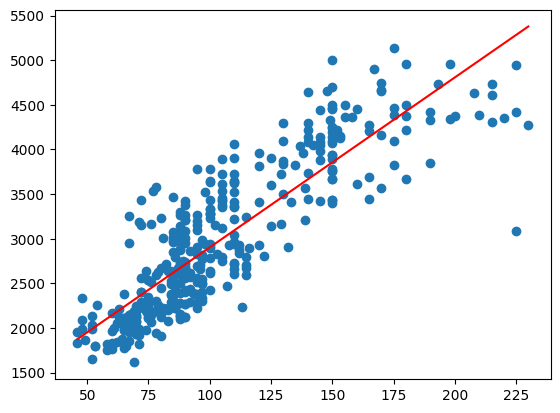

In [25]:
scatter(dfclean.Horsepower, dfclean.Weight_in_lbs);
plot(xplot[:, 2], yplot, color="red");

# Normal Equations

In [26]:
Xp = hcat(ones(size(X, 1)), X);

In [27]:
θ = inv(Xp'*Xp)*Xp'*Y

2-element Array{Float64,1}:
 984.500326770239   
  19.078161552697466

In [28]:
yplot = [h(x, θ) for x in eachrow(xplot)]

2-element Array{Float64,1}:
 1862.0957581943226
 5372.477483890656 

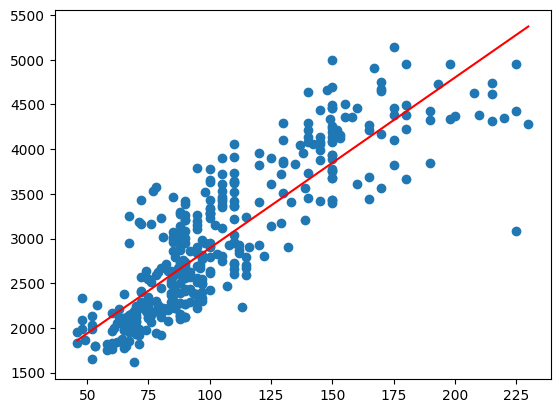

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efec087c690>

In [29]:
scatter(dfclean.Horsepower, dfclean.Weight_in_lbs)
plot(xplot[:, 2], yplot, color="red")

In [30]:
# If θ_0 is fixed to 0:

inv(X'*X)*X'*Y

1-element Array{Float64,1}:
 27.378122063833338

# Locally weighted linear regression

In [31]:
function getWeight(x, xpoint, τ)
    exp(- norm(x - xpoint)^2/(2τ^2))
end

function LWLR(h, X, Y, α, θinit, ϵ, maxiter, τ, x)
    converged = false
    θold = θinit
    counter = 0
    X = hcat(ones(size(X, 1)), X)  # for the intercept θ_0
    θnew = Array{Float64}(undef, size(X, 2))
    prepend!(x, 1)
    W = [getWeight(x, xpoint, τ) for xpoint in eachrow(X)]
    while ~ converged
        counter += 1
        θnew = θold
        for i in 1:size(X, 1)
            x = X[i, :]
            y = Y[i]
            w = W[i]
            gradient = w * (y - h(x, θnew)) * x
            θnew = θnew + α * gradient 
        end
        if sum(abs.(θold - θnew)) < ϵ || counter >= maxiter
            converged = true
            # println(counter, " ", abs.(θold - θnew))
        end
        θold = θnew
    end
    θnew
end

LWLR (generic function with 1 method)

In [32]:
xplot = LinRange(minimum(dfclean.Horsepower), maximum(dfclean.Horsepower), 100);
xplot = hcat(ones(100), xplot);

In [33]:
θ_s = [LWLR(h, X, Y, 1e-9, [200, 10], 1e-4, 10000, 20, [xplot[i, 2]]) for i in 1:size(xplot, 1)];

In [34]:
yplot = [h(xplot[i, :], θ_s[i]) for i in 1:size(xplot, 1)];

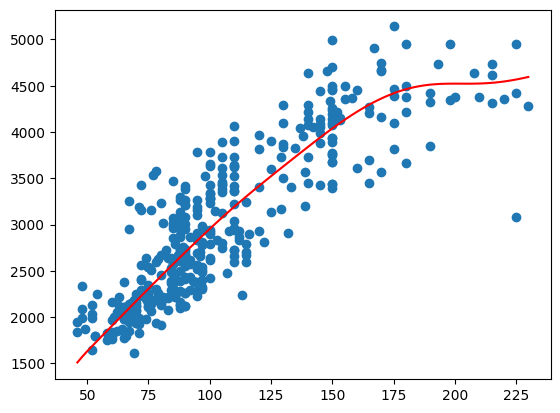

In [35]:
scatter(dfclean.Horsepower, dfclean.Weight_in_lbs);
plot(xplot[:, 2], yplot, color="red");